In [1]:
pip install ipywidgets

You should consider upgrading via the '/home/eusse/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Introduction

In this project, an interactive widget is developed to visualize the radiation spectrum of a black body as its temperature varies, plotting the intensity as a function of wavelength. In addition, a small interactive widget is generated in which the user can vary the temperature of the black body and the range of wavelengths to know the intensity in that interval.


In [2]:
#Useful packages to calculate

import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize

In [3]:
#parameters

c=3e8 #Speed of light [m/s]
h=6.63e-34 #Planck's constant [J*s]
k=1.38e-23 #Boltzman's constant [J/K]
params=[c,h,k]

# Marco teórico 

### Variables to use:

$\lambda: Wavelength \ (nanometers) $

$T: Absolute \ temperature \ (Kelvin) $

$c: Speed \ of \ light = 3x10^8 \  \frac{meters}{seconds} $

$h: Planck's \ constant = 6.63x10^{-34} \ Joules*seconds $

$k= Boltzman's \ constant = 1.38x23 \ \frac{Joules}{Kelvin} $



## Wien's Displacement Law 

The wavelength with the associated radiation maximum of a blackbody can be found by calculating the first derivative of the Plank distribution in terms of the wavelength:

$$ \frac {d} {d\lambda} \left(
\frac{1}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}\right) = 0 \ (1)$$

Obtaining the transcendental equation:

$$5(e^x - 1) - xe^x =0  \ (2)$$ 

with: $$x=\frac{hc}{\lambda_m k T} \ (3)$$

We find the root of equation $(1)$ using `scipy.optimize.newton`:

In [4]:
def Eq(z):
    return 5*(np.exp(z)-1) - z*np.exp(z)

z=np.round(optimize.newton(Eq,5),3)

With the value of $x$ we can solve for $\lambda_m$ equation $(3)$:

$$\lambda_m =\frac{hc}{kTx} \ (4)$$

In [5]:
def λm(T,args=(params,)):
    return h*c/(k*z*T)

## Stefan-Boltzman Law

The wave intensity per unit wave of a black body is given by:

$$ \frac {dW_\lambda} {d\lambda}= \frac{2 \pi h c^2}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}  \ (5)$$

In [6]:
def dW_dλ(λ,T,args=(params,)):
    return 2*np.pi*h*(c**2)/((λ**5)*(np.exp(h*c/(λ*k*T))-1))

To calculate the total intensity of the radiation emitted by a black body we integrate the equation $(5)$ for all wavelengths:

$$W = \int\limits_0^\infty dW_\lambda = \int\limits_0^\infty \frac{2 \pi h c^2}{\lambda^5 (e^{\frac{hc}{\lambda_m k T}}-1)}  \ (6)$$ 

applying on equation $(6)$: substitution $x=\frac{hc}{\lambda k T}$

we have equation:
$$W= \frac{2 \pi k^4 T^4}{c^2 h^3} \int\limits_0^\infty \frac{x^3}{e^x -1}dx \ (7)  $$

we resolve the integral using `integrate.quad`: 

In [7]:
def F(x):
    return x**3/(np.exp(x)-1)
    
def W(λ1,λ2,T,args=(params,)):
    x1=h*c/(k*T*λ2)
    x2=h*c/(k*T*λ1)
    C=2*np.pi*(k**4)*(T**4)/((c**2)*(h**3))
    return C*integrate.quad(F,x1,x2)[0]

def W_total(T):
    return np.round(W(1e-8,np.inf,T),0)    

Changing the limits of integration of equation $(7)$ we can also find the total intensity between two desired wavelengths:

$$W= \frac{2 \pi k^4 T^4}{c^2 h^3} \int\limits_ {x_1}^{x_2} \frac{x^3}{e^x -1}dx \ (8)  $$

# Plots and results

In [8]:
#Useful packages for interactive widgets

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib nbagg

**Slide the cursor at the bottom to change the black body temperature and observe 
the change in the intensity vs. wavelength graph.


<IPython.core.display.Javascript object>


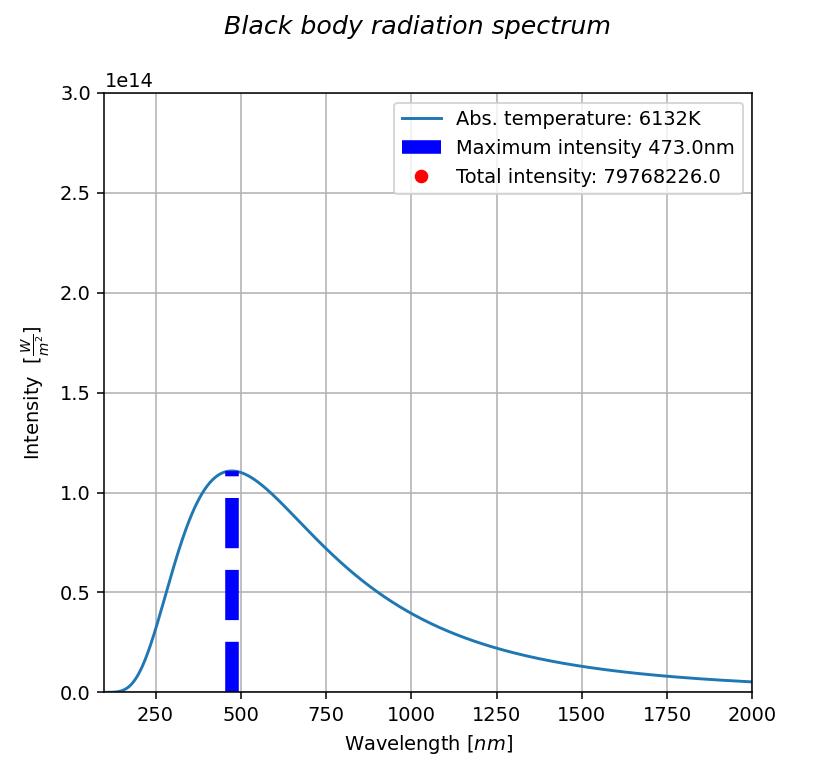

interactive(children=(IntSlider(value=5500, description='Abs. temperature.(K):', layout=Layout(height='50%', l…

In [9]:
print('''**Slide the cursor at the bottom to change the black body temperature and observe 
the change in the intensity vs. wavelength graph.''')

λ=np.linspace(100e-9,2000e-9,1000) #Generates an array with wavelengths
fig, ax = plt.subplots(1, figsize=(4.3, 4))#Creates canvas for plotting
plt.suptitle('Black body radiation spectrum', size=13, style='italic' )



def update_plot(S): #define plots to later interaction
    
    ax.clear() #cleans canvas when the temperature is changed with the slider 
    λmax=λm(S) #calculate the position of the maximum with equation (4)
    
    #This block generates a range of colors according to wavelength.
    
    if 390 <= λmax*1e9 <= 430:
        color='purple'
    
    if 430 <= λmax*1e9 <= 450:
        color='violet'
        
    if 450 <= λmax*1e9 <= 480:
        color='blue'
    
    if 480 <= λmax*1e9 <= 530:
        color='green'
    
    if 530 <= λmax*1e9 <= 580:
        color='yellow'
    
    if 580 <= λmax*1e9 <= 640:
        color='orange'
        
    if 640 <= λmax*1e9 <= 800:
        color='red'

    
    
    ax.plot(λ*1e9, dW_dλ(λ,S), 
    label='Abs. temperature: {}K'.format(S)) #intensity vs wavelength plot
    
    ax.plot((λmax*1e9,λmax*1e9),
    (0,dW_dλ(λmax,S)),'--',color=color, lw=7,
    label='Maximum intensity {}nm'.format(np.round(λmax*1e9),2))#Wavelength where the intensity is maximum
    

    ax.plot(0,0,'ro',label='Total intensity: {}'.format(W_total(S)))#Displays the total radiated intensity
    
    

    ax.set_xlim(λ[0]*1e9, λ[-1]*1e9) #x limit
    ax.set_ylim(0, 3e14) #y limit
    ax.legend(loc=1) #legend ubication on canvas
    plt.xlabel('Wavelength [$nm$]', size=10)
    plt.ylabel(r'Intensity  [$\frac{W}{m^2}$]', size=10)
    plt.grid()
    plt.show()


S = widgets.IntSlider(min=3674, max=7400, value=5500, description='Abs. temperature.(K):'
    ,layout=widgets.Layout(width='50%', height='50%',left='True'))#slider to interact with graphics
    
widgets.interactive(update_plot, S=S) #Generates interaction with the graphic


In [10]:
#Code for calculating intensity between two desired wavelengths varying temperature

print('''**Slide to modify wavelength range and blackbody temperature''')

def update_function(M,R): #function to interact later
    
    a=np.round(W(M[0]*1e-9,M[-1]*1e-9,R),2)
    print(r'The intensity between {}nm and {}nm is: {} W/m^2'.format(M[0],M[-1],a))
    

M = widgets.FloatRangeSlider(min=392, max=790, value=[500,600], description='Wavelength(nm):',layout=widgets.Layout(width='50%', height='50%',left='True'))
R = widgets.IntSlider(min=3674, max=7400, value=5500, description='Abs. temeperature(K):',layout=widgets.Layout(width='50%', height='50%'))


widgets.interactive(update_function, R=R, M=M)

**Slide to modify wavelength range and blackbody temperature


interactive(children=(FloatRangeSlider(value=(500.0, 600.0), description='Wavelength(nm):', layout=Layout(heig…

**Note:** _If you have issues with the widgets activate them in the terminal:_ 

`jupyter nbextension enable --py widgetsnbextension` 

# Bibliography

[1] La radiación del cuerpo negro: http://www.sc.ehu.es/sbweb/fisica/cuantica/negro/radiacion/radiacion.htm

[2] Learn Jupyter Notebooks (pt.4) Using Interactive Widgets: https://www.youtube.com/watch?v=SN0Bflf14C4

[3] Widgets_example.ipynb:https://github.com/markjay4k/fourier-transform/blob/master/widgets_example.ipynb 

[4] Sears Zemansky, Física universitaria 12 ed, Vol 2 . Pag 1336-1337

[5] Black body radiation simulation: http://physics.bu.edu/~duffy/classroom.html 


